# Second Level Analysis 

## 1. Prep: Load packages and data

**Section Description:**  
Using `pickle` we load the fitted FirstLevelModel object we've created earlier 

In [1]:
import pickle
import glob
import os
import numpy as np
import pandas as pd
import glob
from nilearn import plotting
from atlasreader import create_output

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

In [4]:
flms_folder = '' # name of folder containing firstlevelmodel objects

flms_dir = glob.glob(r'path_to_folder/{}/*.plk'.format(flms_folder))

We now want to load the models from Pickle. To load a saved model from a Pickle file, wee pass the pickeld model into the Pickle load() function. This will deserialize the model. By assigning it back to a model object, we can run our normal model functions. 

**OBS:** sometimes the error: "the data was truncated" will appear, then you have to remove the participants whos data it is:

Now, we are ready to load in the models: 

In [5]:
flms = [] # empty list to store our fitted first level model objects

# load the models
for model in flms_dir:
    pickled_model = pickle.load(open(model,'rb')) 
    flms.append(pickled_model)

**Description: End of Section**  
We end with `flms` that is a list of fitted first level models

## 2. Create SecondLevelModel object + fit this to data

Alright, so now we have 33 fitted `FirstLevelModel` objects (stored in `flms`). We will use these for our second-level model. Like `FirstLevelModel` objects, the `SecondLevelModel` object has a `fit` method, but it is a bit more complicated, because there are **different ways to specify the input for second-level models** (i.e., the `second_level_input` parameter):
1. a list of fitted `FirstLevelModel` objects (easy, but limited to within-subject/run analyses only);
2. a list of first-level contrast images (i.e., with $c\hat{\beta}$ values);
3. a pandas `DataFrame` with information about the lower-level inputs (useful when using first-level output from other packages, such as FSL, but for Nilearn-only analyses, this is not very useful)

The first method is quite efficient (in terms of code), because it assumes that you are only interested in an intercept-only group-level model (i.e., the average of a particular first-level contrast across participants), and you can leave out the second-level design matrix. We'll show this below:

In [13]:
from nilearn.glm.second_level import SecondLevelModel

### 2.1. METHOD 1 for fitting 2nd level model
This is the method where we use fitted `FirstlevelModel` objects as inputs. 
This method is quite efficient (in terms of code), because it assumes that you are only interested in an intercept-only group-level model (i.e., the average of a particular first-level contrast across participants), and you can leave out the second-level design matrix. 


The `smoothing_fwhm` argument: specifies the full-width at half-maximum (FWHM) of the Gaussian smoothing kernel to be applied to the data. This smoothing is applied to the data at the second level of analysis, after the first-level model has been fit to each individual subject's data. The purpose of smoothing the data at the second level is to increase the signal-to-noise ratio (SNR) of the data, which can improve the reliability and sensitivity of the results. It can also help to reduce the effects of spatial noise and other sources of variability in the data. The FWHM value specifies the size of the smoothing kernel, with larger values corresponding to more aggressive smoothing. In general, it is recommended to use a conservative smoothing kernel with a FWHM value of around 4-8 millimeters, although the optimal value will depend on the specific data and the goals of the analysis. Overall, the smoothing_fwhm argument in the SecondLevelModel function allows users to control the amount of smoothing applied to the data at the second level of analysis, which can help to improve the reliability and interpretability of the results.

In [14]:
slm_method1 = SecondLevelModel(smoothing_fwhm=8.0)
slm_method1.fit(flms)

/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


SecondLevelModel(smoothing_fwhm=8.0)

**Description: End of section**  
We have `slm_method1` that is a fitted second level model, but to which no contrast has been specified.  

## 3. Compute contrast (create z-map) emotional - neutral

### 3.1. METHOD 1 for computing contrast

In [15]:
# using method 1: only possible using contract definitions already present in the first-level model (because there is no second-level design matrix)
zmaps_method1_emoneu = slm_method1.compute_contrast(first_level_contrast='Emotional - Neutral', output_type='z_score') # avg (across participants) group-lvl contrast of "emotional" - neutral

/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/min

## 4. Create thresholded maps

We can use different functions to do this, they enable different choices.  
Hereunder we are making 4 different maps: 

### Thresholding: Emotional - Neutral

In [19]:
from scipy.stats import norm

########### MAP 1: ###########

from nilearn.image import threshold_img
thresholded_map_emoneu = threshold_img(
    zmaps_method1_emoneu,
    threshold=3.29,
    cluster_threshold=10,
    two_sided=True,
)

########### MAP 2: ###########
from nilearn.glm import threshold_stats_img
thresholded_map1_emoneu, threshold1_emoneu = threshold_stats_img(
    zmaps_method1_emoneu,
    alpha=.001,
    height_control='fpr',
    cluster_threshold=10,
    two_sided=True,
)

########### MAP 3: ###########
# Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.
thresholded_map2_emoneu, threshold2_emoneu = threshold_stats_img(
    zmaps_method1_emoneu, 
    alpha=0.01, 
    height_control='fdr') 

print('The FDR=0.01 threshold is %.3g' % threshold2_emoneu)

########### MAP 4: ###########
thresholded_map3_emoneu, threshold3_emoneu = threshold_stats_img(
    zmaps_method1_emoneu, 
    alpha=.05, 
    height_control='bonferroni') 
    
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3_emoneu)


The FDR=0.01 threshold is 4.17
The p<.05 Bonferroni-corrected threshold is 5.25


## 5. Visualise on Glass Brain

### Visualising The Contrast: Emotional - Neutral (For all 4 thresholded maps)

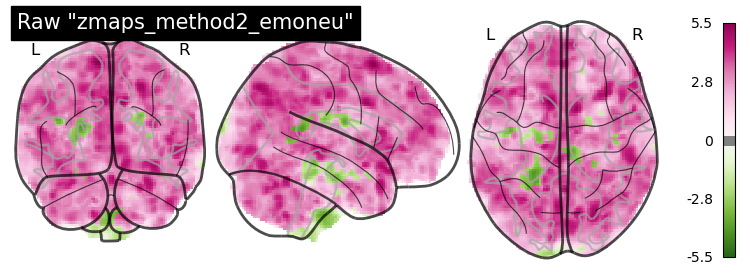

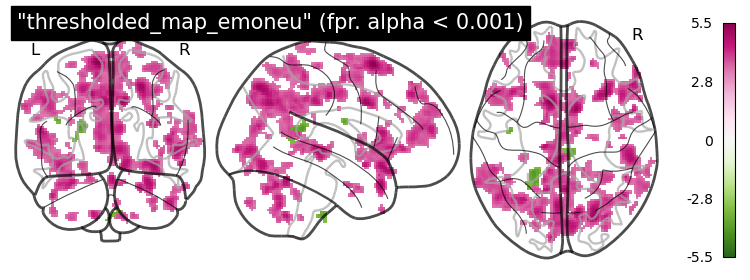

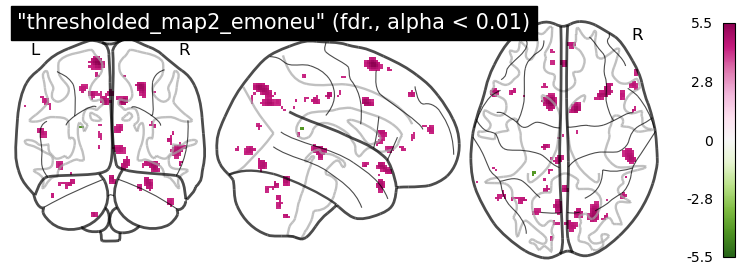

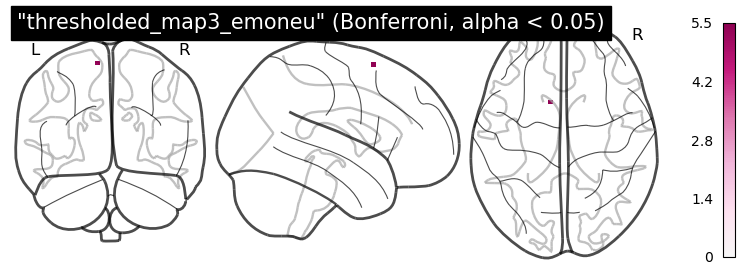

In [20]:
# Raw 'zmaps_method2_emoneu'
plotting.plot_glass_brain(zmaps_method1_emoneu, colorbar=True,
                          title='Raw "zmaps_method2_emoneu"',
                          plot_abs=False, cmap=matplotlib.cm.get_cmap('PiYG_r'))

# 'thresholded_map_emoneu'
plotting.plot_glass_brain(thresholded_map_emoneu, colorbar=True,
                          title='"thresholded_map_emoneu" (fpr. alpha < 0.001)',
                          plot_abs=False, cmap=matplotlib.cm.get_cmap('PiYG_r'))


# 'thresholded_map2_emoneu'
plotting.plot_glass_brain(thresholded_map2_emoneu, colorbar=True,
                          title='"thresholded_map2_emoneu" (fdr., alpha < 0.01)',
                          plot_abs=False, cmap=matplotlib.cm.get_cmap('PiYG_r'))

# 'thresholded_map3_emoneu'
plotting.plot_glass_brain(thresholded_map3_emoneu, colorbar=True,
                          title='"thresholded_map3_emoneu" (Bonferroni, alpha < 0.05)',
                          plot_abs=False, cmap=matplotlib.cm.get_cmap('PiYG_r'))

plotting.show()

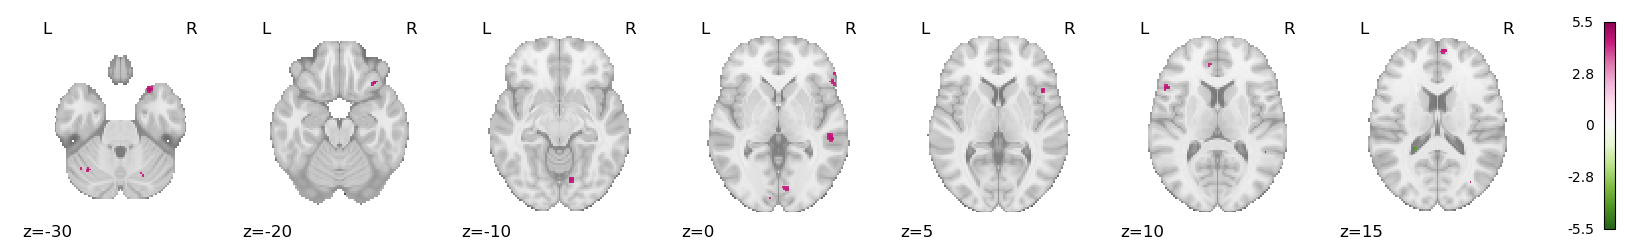

In [23]:
from nilearn.plotting import plot_stat_map

# the auto parameter means that the function determines the threshold "magically by analysis of the img: https://nilearn.github.io/dev/modules/generated/nilearn.plotting.plot_stat_map.html"

plot_stat_map(thresholded_map2_emoneu, cmap='PiYG_r',threshold='auto', cut_coords=[-30,-20,-10,0,5,10,15],
              display_mode='z',  black_bg=False,
              title=None) # 'Group [Emotional-Neutral] effect (FDR, alpha < 0.01)'

## 6. Visualise and investigate clusters using AtlasReader

In this step we'll use `Atlasreader` to both get information about the clusters but also visuale the zmaps.   
See the github https://github.com/miykael/atlasreader to get information about the function!  
They provide this example noteboook (https://github.com/miykael/atlasreader/blob/master/notebooks/atlasreader.ipynb) where all parameters are explained and examplified!

In [ ]:
outdir = 'atlasreader_results' # directory where output is stored
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [ ]:
######### Using the create_coutput() function ############

# Emotional - Neutral: creating output using "thresholded_map3_emoneu"
create_output(
    filename = thresholded_map3_emoneu,
    cluster_extent = 5, 
    atlas='default',
    voxel_thresh=1.96, 
    direction='both',
    outdir=os.path.join(outdir, 'results_emoneu')
)

**Investigate the clusters:**

Here we import the output that we've created using the create_output function

In [ ]:
# Emotional - Neutral
peak_info_emoneu = pd.read_csv(os.path.join(outdir, 'results_emoneu', 'atlasreader_peaks.csv'))
display(peak_info_emoneu.head(5))

cluster_info_emoneu = pd.read_csv(os.path.join(outdir, 'results_emoneu', 'atlasreader_clusters.csv'))
display(cluster_info_emoneu.head(5))

**Visualising Clusters:**

In [ ]:
# Emotional - Neutral

# figure size in inches optional
rcParams['figure.figsize'] = 10,5

# read images
img_A = mpimg.imread(os.path.join(outdir, 'results_emoneu', 'atlasreader.png'))
img_B = mpimg.imread(os.path.join(outdir, 'results_emoneu', 'atlasreader_cluster01.png'))

# display images
fig, ax = plt.subplots(2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

## 7. Perform permutation test

**6.1 Create an image for comparison**

Next, we compute the (corrected) p-values with a parametric test to compare them with the results from a nonparametric test.

In [13]:
import numpy as np
from nilearn.image import get_data, math_img

#Get an image of p-values
p_val = slm_method1.compute_contrast(first_level_contrast='Emotional-Neutral',output_type='p_value')
# Get the number of voxels in the image
n_voxels = np.sum(get_data(slm_method1.masker_.mask_img_))
# Making an image with significant values, correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    '-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)),
    img=p_val,
)

#Check image shape
print(neg_log_pval.shape)

/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/min

(109, 129, 108)


<string>:1: RuntimeWarning: divide by zero encountered in log10


**6.2 Perform Permutations:**

see: https://nilearn.github.io/stable/modules/generated/nilearn.glm.second_level.non_parametric_inference.html#nilearn.glm.second_level.non_parametric_inference

In [14]:
from nilearn.glm.second_level import non_parametric_inference

# n_perm=1000 for the sake of time. Ideally, this should be 10,000, but the upper limit on permutations is 2 to the power of N.
n_perm=10000

"""
#We base the analysis on a contrast image (z-score map) from each participant
second_level_input2=[]
#Put the NIimg zmaps into a list.
for ii in range(21):
    second_level_input2.append(second_level_input[ii].zmap)
"""

fl_cons = []
for flm in flms:
    con = flm.compute_contrast('Emotional-Neutral', stat_type='t', output_type='effect_size') 
    fl_cons.append(con)

design_matrix = pd.DataFrame(
    [1] * len(fl_cons), # replaced 'len(second_level_input2)'
    columns=['intercept'],
)
#print(design_matrix)

#Calculate p-values using permutation
out_dict = non_parametric_inference(
    fl_cons, # replaced 'second_level_input2'
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=n_perm,  
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=1,
)

/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/users/sirid/min

/users/sirid/miniconda3/envs/env_fmri_analysis/lib/python3.8/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


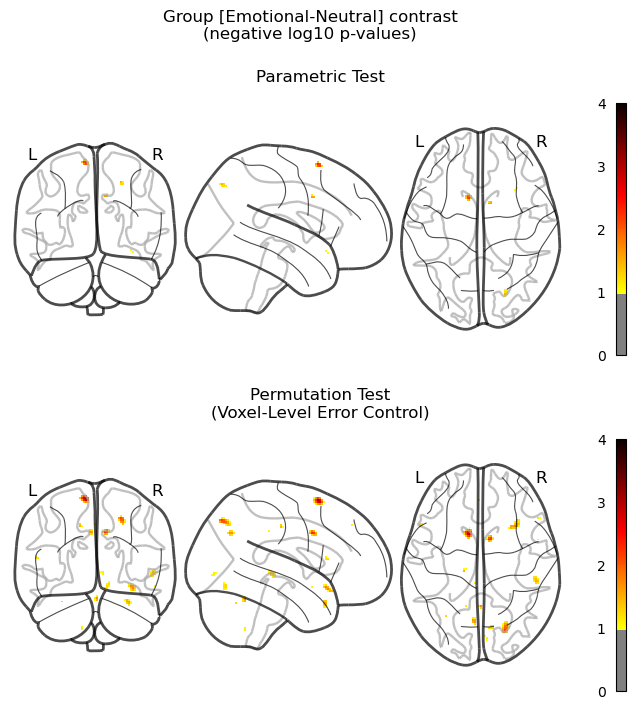

In [15]:
import matplotlib.pyplot as plt
# Prepare thresholds for plotting

threshold_log = round(-np.log10(1 / 20))  # p < 0.05 
vmax = round(-np.log10(1 / n_perm)) # minimal p-value possible with the number of permuations

cut_coords = [0]

#Prepare images to plot
IMAGES = [
    neg_log_pval,
    out_dict
]
TITLES = [
    'Parametric Test',
    'Permutation Test\n(Voxel-Level Error Control)',
]

#Make loop with plots
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
i_row=0
for j_row in range(2):
        ax = axes[j_row]     
        plotting.plot_glass_brain(
            IMAGES[img_counter],
            colorbar=True,
            vmax=vmax,
            plot_abs=False,
            cut_coords=cut_coords,
            threshold=threshold_log,
            figure=fig,
            axes=ax,
        )

        
        ax.set_title(TITLES[img_counter])
        img_counter += 1


fig.suptitle('Group [Emotional-Neutral] contrast\n(negative log10 p-values)')
plt.show()